## GMM implementation in PyMC3

Hopefully eventually with DP prior

Run the title cell for latex shortcuts

$$ \newcommand{\N}{\mathcal{N}}$$

### Parametric version

Lets say we have N data points that we assume to be drawn from K different MVNs with means $\mu$ and . The model is


$$ \mu_k \sim \N(0, 20)$$
$$ L_k = \text{Cholesky}(\Sigma_k) \sim LKJ(\eta)$$
$$ w \sim Dir(\alpha)$$
$$ c_i \sim Cat(w)$$
$$ x_i | c_i \sim \N(\mu_{c_i}, \Sigma_{c_i})$$

Were going to learn $\mu, L, w,\text{ and } c_i$ using MCMC

In [72]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
rc("text", usetex=False)
rc("font", family = "serif")
rc("figure",figsize=(9,6))
rc("figure",facecolor="white")
%config InlineBackend.figure_format = 'retina'
import pymc3 as pm
import os
from matplotlib.patches import Ellipse
from sklearn.utils import shuffle


def draw_elliptical_contour(mu, L=None, cov=None, fill=True, alpha=0.3):
    if cov is not None:
        sigma = cov
    else:
        sigma = unpack_lt(L)
    evals,evecs = np.linalg.eig(sigma)
    v = evecs[:,1]
    a = np.arctan2(v[1],v[0])*(180/np.pi)
    d = 2*np.sqrt(5.991*evals)
    return Ellipse(mu, d[1], d[0], angle=a, fill=fill,alpha=alpha)

def unpack_lt(L):
    m = np.zeros((2,2))
    m[0,0], m[1,0], m[1,1] = L 
    return m.dot(m.T)

In [2]:
#Generate the data
N = 500
K_true = 5
true_means = 7*np.random.randn(K_true,2)
true_packed_Ls = pm.LKJCholeskyCov.dist(n=2, eta=2.5, sd_dist=pm.HalfNormal.dist(2.5)).random(size=K_true)
true_w = pm.Dirichlet.dist(a=np.ones(K_true)).random()
grouped_data = []
for i, wi in enumerate(true_w):
    n = np.int(N*wi)
    L = pm.expand_packed_triangular(2,true_packed_Ls[i])
    Sigma = L.dot(L.T)
    grouped_data.append(pm.MvNormal.dist(mu=true_means[i],cov=Sigma).random(size=n))
#grouped_data = np.array(grouped_data)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [4]:
# for i,data_group in enumerate(grouped_data):
#     np.save("small_data/data_{}.npy".format(i), data_group)

In [48]:
for i, file in enumerate(os.listdir("small_data/")):
    arr = np.load("small_data/"+str(file))
    n = int(file[5])
    if i==0:
        small_data = arr
        small_labels = n*np.ones(arr.shape[0])
    else:
        small_data = np.concatenate((small_data, arr))
        
        small_labels = np.concatenate((small_labels,n*np.ones(arr.shape[0]) ))
        
small_data, small_labels = shuffle(small_data, small_labels)

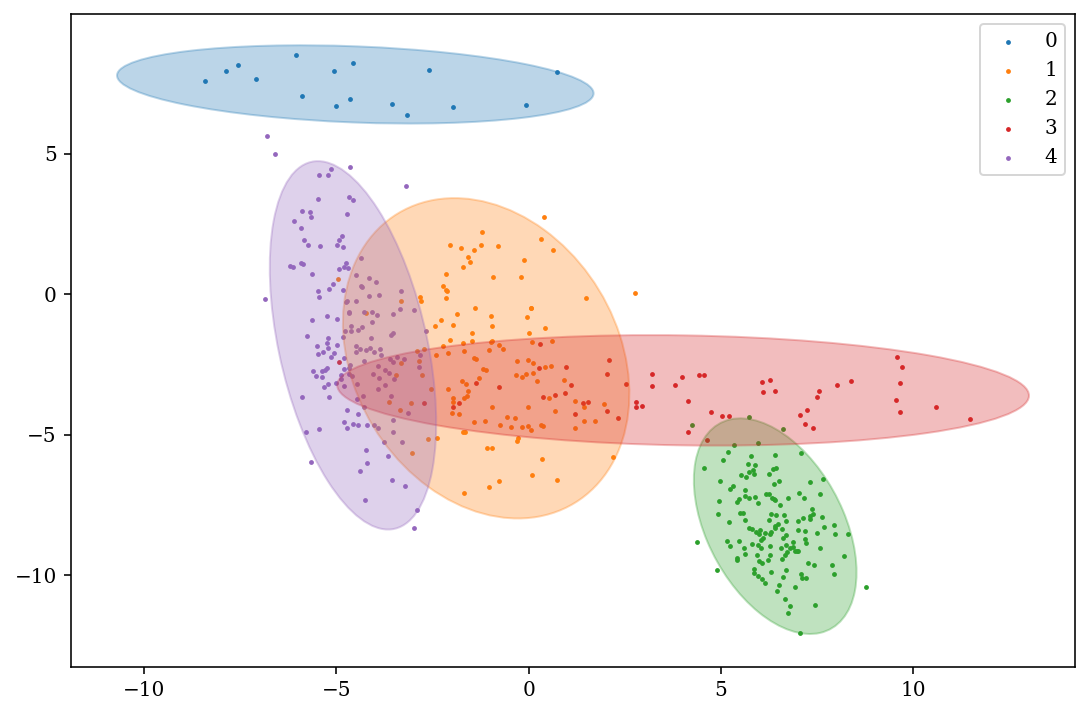

In [73]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i,c in enumerate(grouped_data):
    ax.scatter(c[:,0],c[:,1],s=2,label=str(i))
    e = draw_elliptical_contour(true_means[i], L=true_packed_Ls[i])
    e.set_edgecolor(plt.get_cmap('tab10')(i))
    e.set_facecolor(plt.get_cmap('tab10')(i))
    ax.add_patch(e)
plt.legend()
plt.show()

In [52]:
N_per_class = np.array([grouped_data[i].shape[0] for i in range(K_true)])
N_data = N_per_class.sum()
inds = N_per_class.cumsum()
data = np.zeros((N_data,2))
data[:inds[0]]=grouped_data[0]
labels = np.zeros(N_data)
for i in range(1,5):
    data[inds[i-1]:inds[i]] = grouped_data[i]
    labels[inds[i-1]:inds[i]] = i
data, labels = shuffle(data, labels)

In [53]:
with pm.Model() as parametric_model:
    #means = pm.MvNormal('means',mu=np.zeros((K_true,2)), cov=20*np.eye(2), shape=(K_true,2))
    #packed_L_cov = pm.LKJCholeskyCov('packed_L',n=2, eta=2*np.ones(K_true), sd_dist = pm.HalfCauchy.dist(2.5))
    mean_list = []
    chol_list = []
    mvn_list = []
    for i in range(K_true):
        mean_list.append(pm.MvNormal('mean_%d'%i, mu=np.zeros(2), cov=10*np.eye(2), shape=2))
        chol_list.append(pm.LKJCholeskyCov('chol_%d'%i, n=2, eta=2.5, sd_dist=pm.HalfNormal.dist(2.5)))
        mvn_list.append(pm.MvNormal.dist(mu=mean_list[i], chol=pm.expand_packed_triangular(2, chol_list[i])))
    w = pm.Dirichlet('w', a=np.ones(K_true))
    c = pm.Categorical('c', w, shape=N_data)
    x = pm.Mixture('obs',w=w, comp_dists=mvn_list, observed=small_data )

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


In [54]:
with parametric_model:
    full_cat_trace = pm.load_trace('full_categorical_trace/')

In [57]:
df_trace = pm.trace_to_dataframe(full_cat_trace)

In [61]:
full_cat_trace.get_values('c').shape

(5000, 497)

In [52]:
with parametric_model as model:
    step1 = pm.CategoricalGibbsMetropolis(vars=[c])
    step2 = pm.Metropolis(vars=model.cont_vars)
    trace = pm.sample(5000, chains=1, step=[step1, step2])
    pm.save_trace(trace, "full_categorical_trace")

Sequential sampling (1 chains in 1 job)
CompoundStep
>CategoricalGibbsMetropolis: [c]
>CompoundStep
>>Metropolis: [w]
>>Metropolis: [chol_4]
>>Metropolis: [mean_4]
>>Metropolis: [chol_3]
>>Metropolis: [mean_3]
>>Metropolis: [chol_2]
>>Metropolis: [mean_2]
>>Metropolis: [chol_1]
>>Metropolis: [mean_1]
>>Metropolis: [chol_0]
>>Metropolis: [mean_0]
100%|██████████| 5500/5500 [50:42<00:00,  1.81it/s]
Only one chain was sampled, this makes it impossible to run some convergence checks


In [46]:
with parametric_model as model:
    pm.save_trace(trace, "small_trace.npy")

In [7]:
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

/opt/anaconda3/lib/python3.7/site-packages/theano/tensor/subtensor.py:2339: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  out[0][inputs[2:]] = inputs[1]


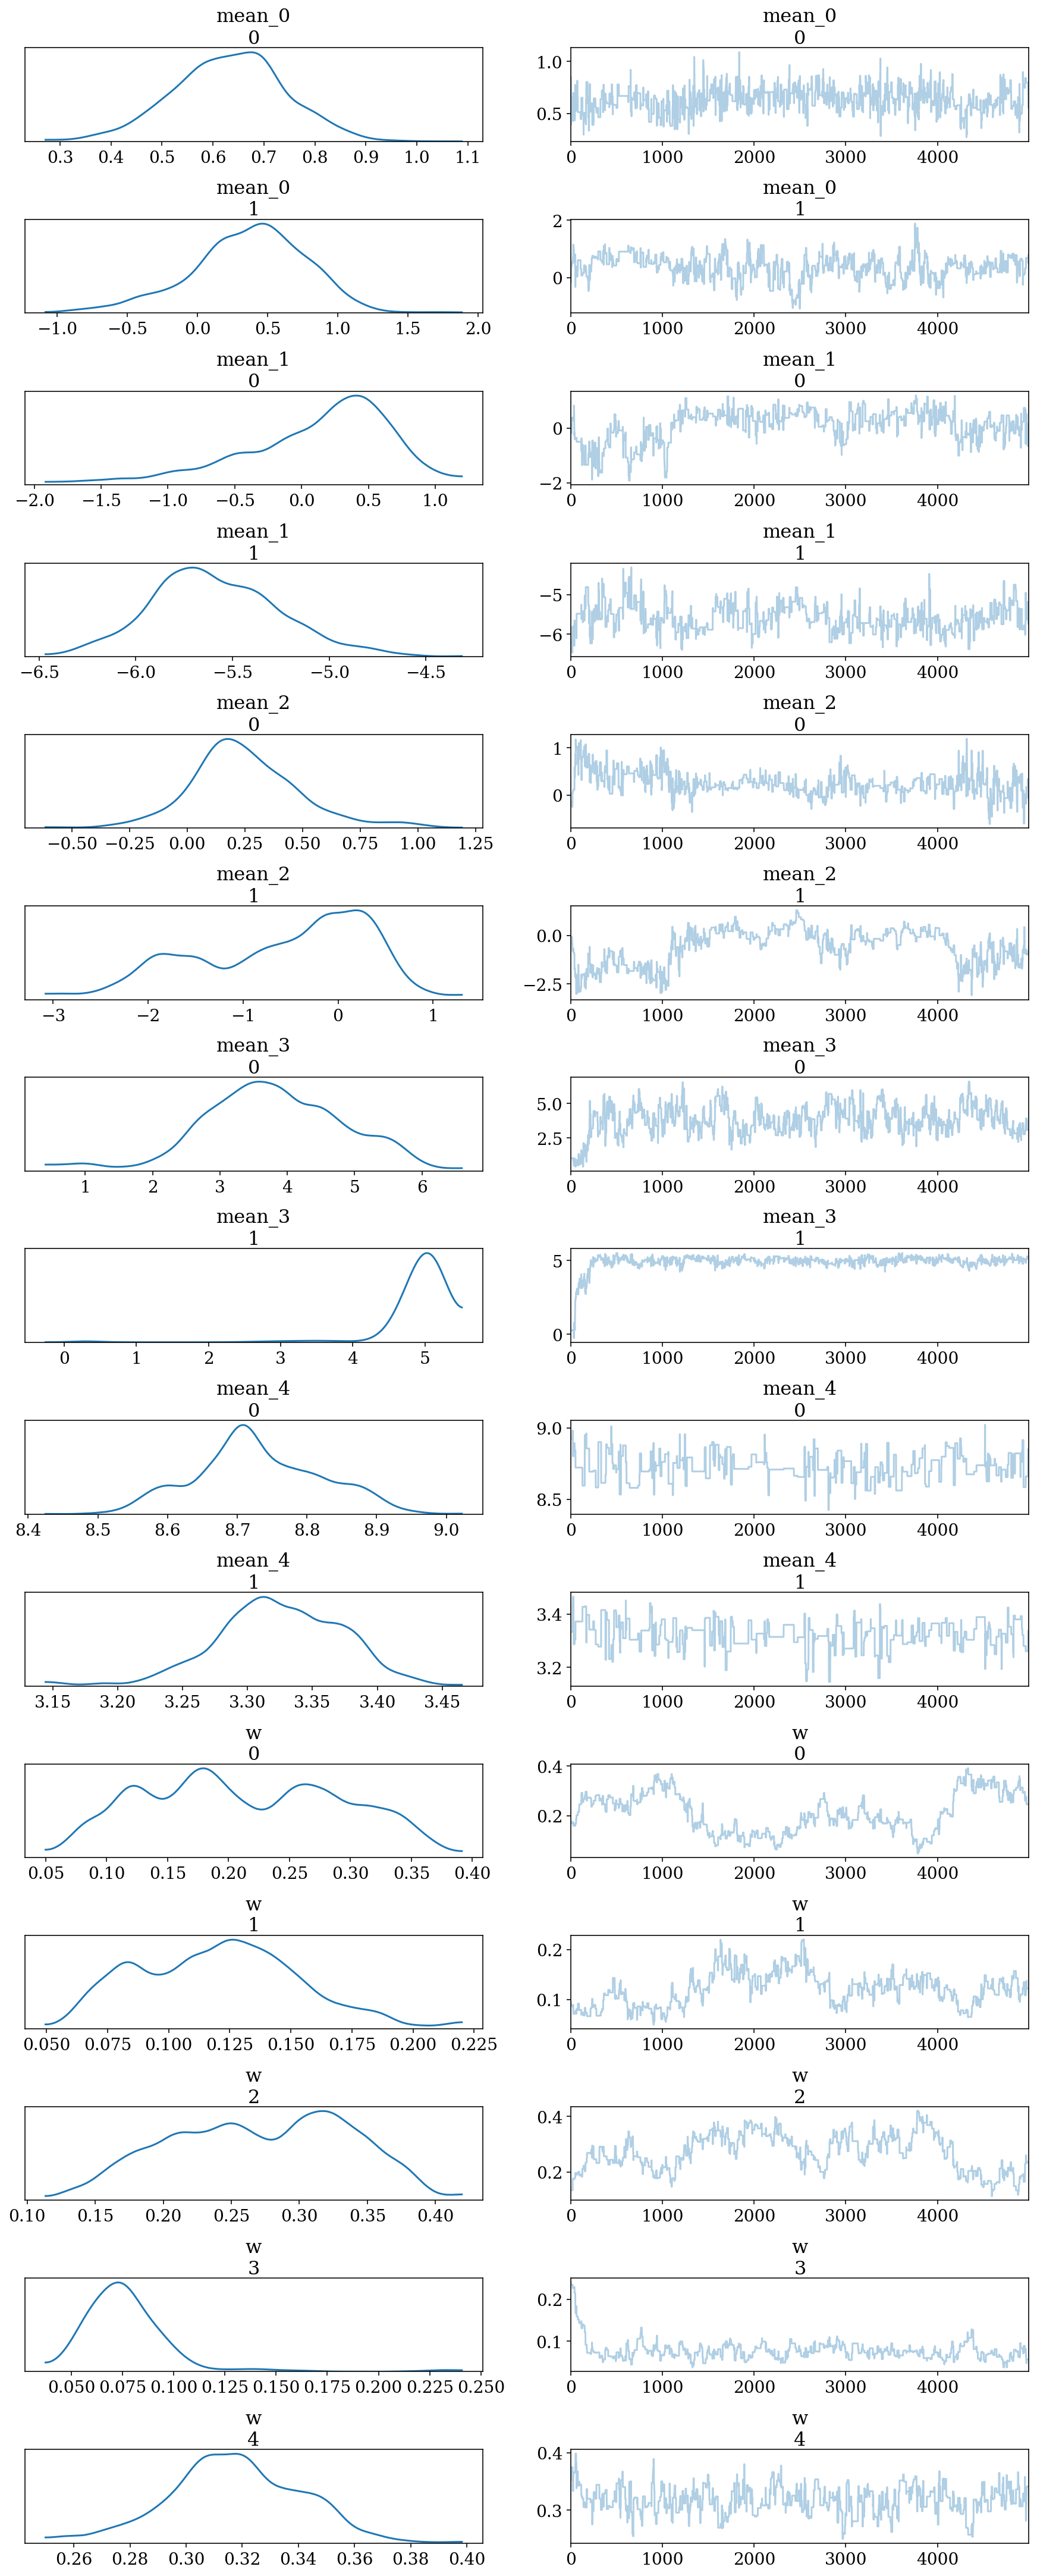

In [62]:
names = ['mean_{}'.format(i) for i in range(K_true)]
names.append('w')
pm.traceplot(full_cat_trace, var_names=names)
plt.show()

In [70]:
empirical_covs = np.zeros((5,2,2))
empirical_means = np.zeros((5,2))
for i in range(K_true):
    empirical_covs[i] = np.cov(small_data[small_labels==i].T)
    empirical_means[i] = np.mean(small_data[small_labels==i], axis=0)

In [82]:
map_means = np.array([full_cat_trace.get_values('mean_{}'.format(i)).mean(axis=0) for i in range(K_true)])
map_chols = np.array([full_cat_trace.get_values('chol_{}'.format(i)).mean(axis=0) for i in range(K_true)])
map_w  = full_cat_trace.get_values('w').mean(axis=0)

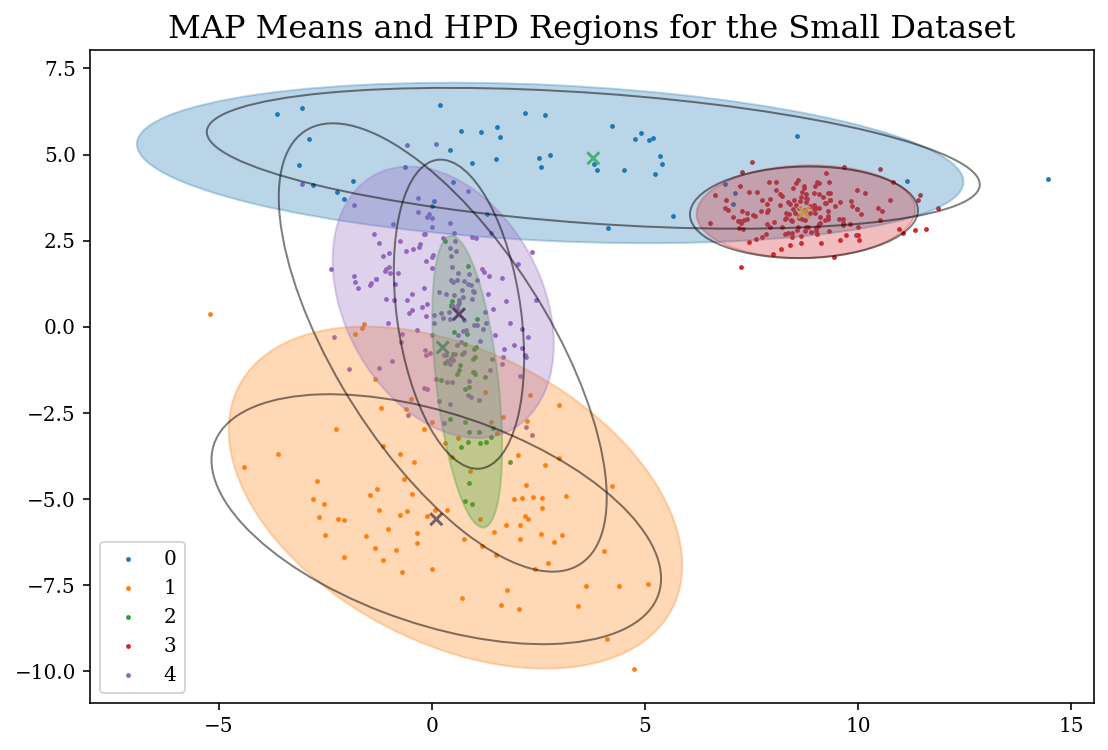

In [127]:
fig = plt.figure()
ax = fig.add_subplot(111)

for i in range(K_true):
    pts = small_data[small_labels==i]
    ax.scatter(pts[:,0], pts[:,1],s=2,label=str(i))
    e = draw_elliptical_contour(empirical_means[i], cov=empirical_covs[i])
    e.set_edgecolor(plt.get_cmap('tab10')(i))
    e.set_facecolor(plt.get_cmap('tab10')(i))
    ax.add_patch(e)
for i,chol in enumerate(map_chols):
    e = draw_elliptical_contour(map_means[i], L=chol, fill=False, alpha=0.5)
    e.set_edgecolor('k')
    ax.add_patch(e)
ax.scatter(map_means[:,0],map_means[:,1], marker="x", c=np.arange(5))
# num=150
# ax.scatter(small_data[num,0], small_data[num,1], marker='x', color='m')
plt.title("MAP Means and HPD Regions for the Small Dataset", fontsize=16)
plt.legend()
plt.show()

In [128]:
with parametric_model:
    pp_trace = pm.sample_posterior_predictive(full_cat_trace, 10000, var_names=['c'])

100%|██████████| 10000/10000 [00:00<00:00, 40491.74it/s]


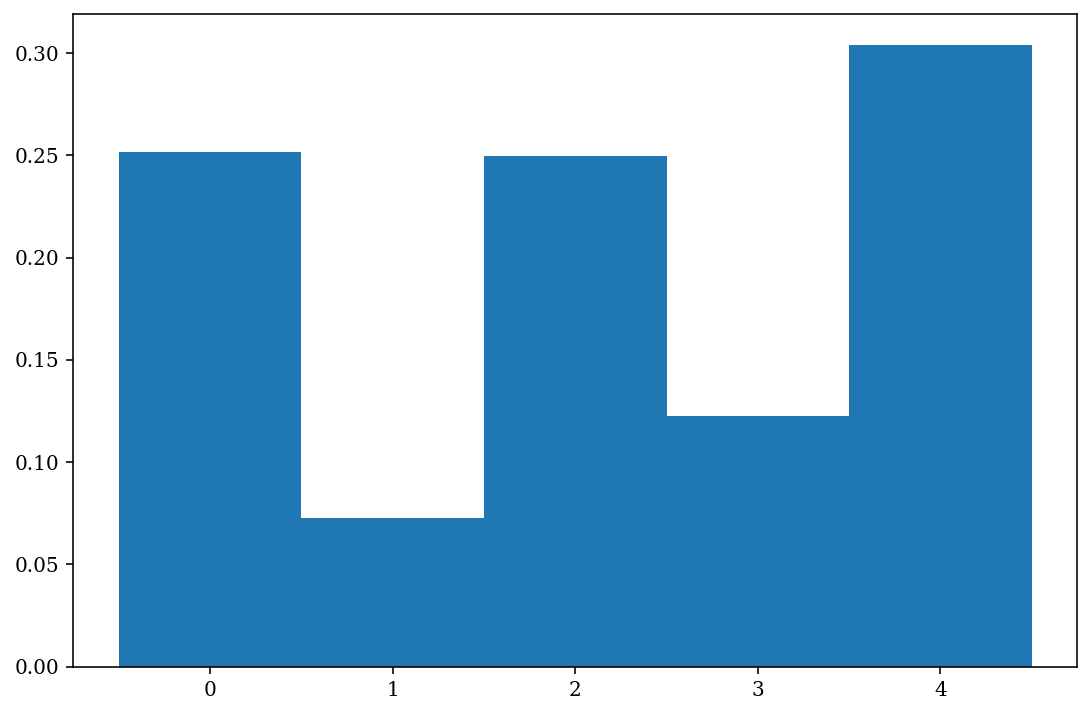

In [129]:
plt.hist(pp_trace['c'][num], bins = np.arange(0,6)-0.5, density=True)
plt.show()


### Marginalized Parametric Model

In [74]:
with pm.Model() as marginalized_model:
    #means = pm.MvNormal('means',mu=np.zeros((K_true,2)), cov=20*np.eye(2), shape=(K_true,2))
    #packed_L_cov = pm.LKJCholeskyCov('packed_L',n=2, eta=2*np.ones(K_true), sd_dist = pm.HalfCauchy.dist(2.5))
    mean_list = []
    chol_list = []
    mvn_list = []
    for i in range(K_true):
        mean_list.append(pm.MvNormal('mean_%d'%i, mu=np.zeros(2), cov=10*np.eye(2), shape=2))
        chol_list.append(pm.LKJCholeskyCov('chol_%d'%i, n=2, eta=2.5, sd_dist=pm.HalfNormal.dist(2.5)))
        mvn_list.append(pm.MvNormal.dist(mu=mean_list[i], chol=pm.expand_packed_triangular(2, chol_list[i])))
    w = pm.Dirichlet('w', a=np.ones(K_true))
    x = pm.Mixture('obs',w=w, comp_dists=mvn_list, observed=data )

In [75]:
with marginalized_model:
    trace = pm.sample(2000, chains=1, cores=4)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (1 chains in 1 job)
NUTS: [w, chol_4, mean_4, chol_3, mean_3, chol_2, mean_2, chol_1, mean_1, chol_0, mean_0]
100%|██████████| 2500/2500 [12:01<00:00,  3.47it/s]
The acceptance probability does not match the target. It is 0.9530754245156149, but should be close to 0.8. Try to increase the number of tuning steps.
Only one chain was sampled, this makes it impossible to run some convergence checks


In [76]:
map_means = np.array([trace.get_values('mean_{}'.format(i)).mean(axis=0) for i in range(K_true)])
map_chols = np.array([trace.get_values('chol_{}'.format(i)).mean(axis=0) for i in range(K_true)])
map_w  = trace.get_values('w').mean(axis=0)

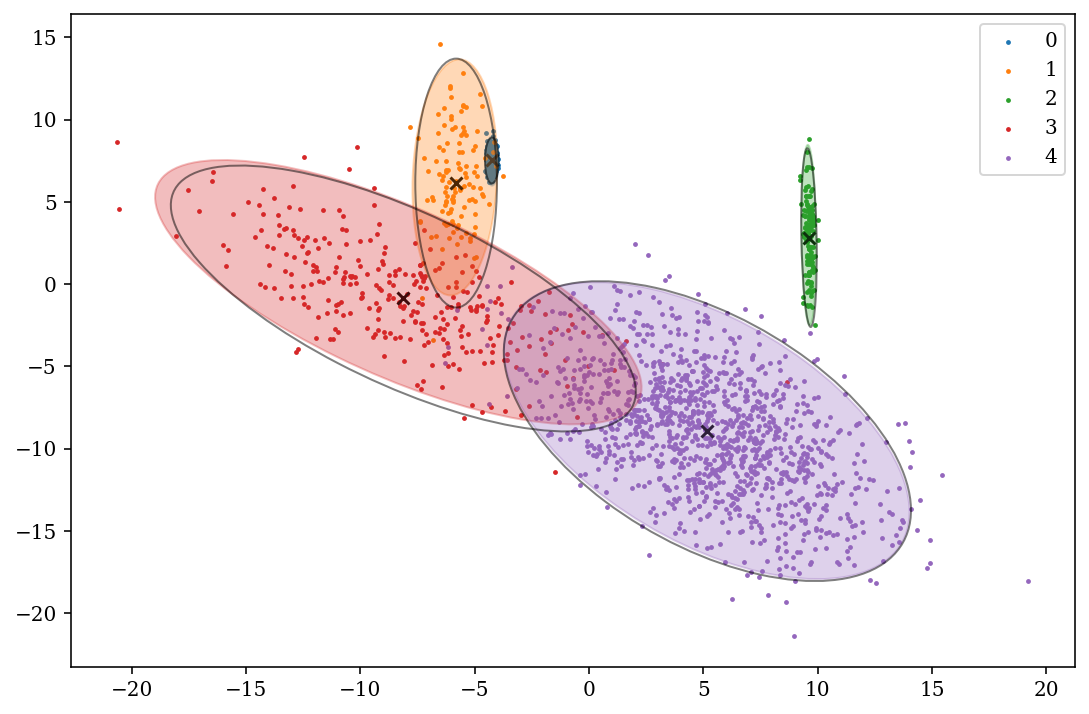

In [77]:
fig = plt.figure()
ax = fig.add_subplot(111)
for i,c in enumerate(grouped_data):
    ax.scatter(c[:,0],c[:,1],s=2,label=str(i))
    e = draw_elliptical_contour(true_means[i], true_packed_Ls[i])
    e.set_edgecolor(plt.get_cmap('tab10')(i))
    e.set_facecolor(plt.get_cmap('tab10')(i))
    ax.add_patch(e)
ax.scatter(map_means[:,0],map_means[:,1], marker="x", color='k')
for i,chol in enumerate(map_chols):
    e = draw_elliptical_contour(map_means[i], chol, fill=False, alpha=0.5)
    e.set_edgecolor('k')
    ax.add_patch(e)
plt.legend()
#plt.savefig("map_gmm.png", dpi=200)
plt.show()

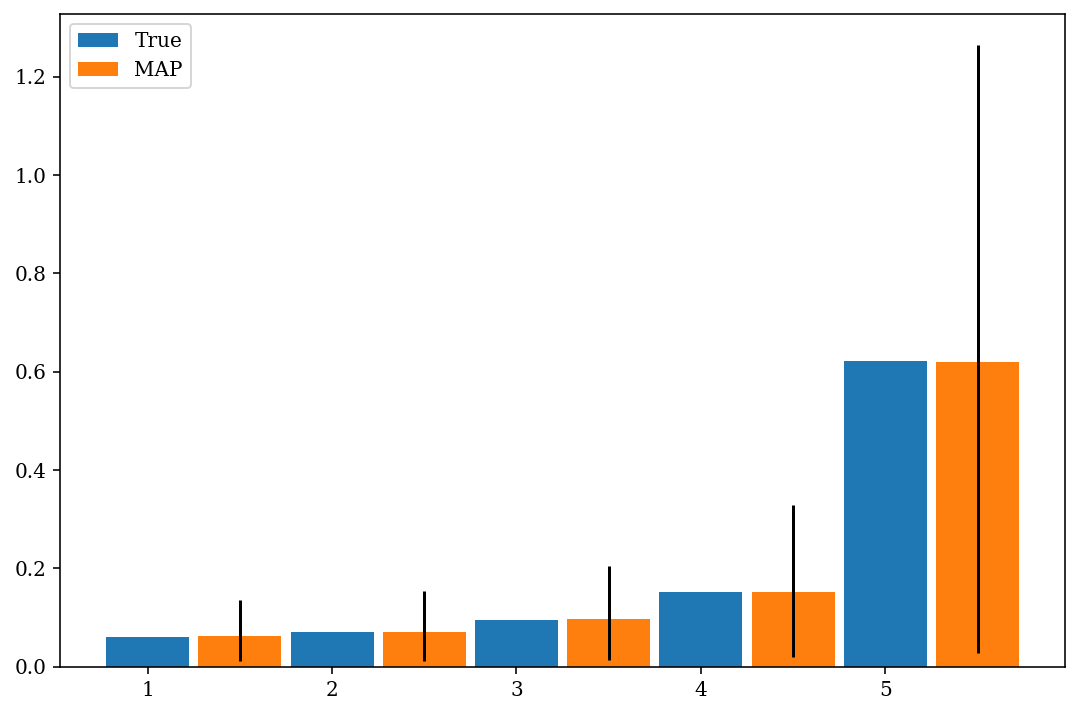

In [78]:
plt.bar(np.arange(K_true)+1,np.sort(true_w), width=0.45,label="True")
plt.bar(np.arange(K_true)+1.5,np.sort(map_w), width=0.45, yerr=pm.stats.hpd(trace.get_values('w'))[np.argsort(map_w)].T,label="MAP")
plt.legend(loc = 'upper left')
plt.savefig('map_gmm_weights.png', dpi=200)
plt.show()